# Adaption Evaluation
Comparision between: 
- MAML
- pretrained model

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import vectorbt as vbt
sns.set()
import plotly.graph_objects as go
from copy import deepcopy
from stock_env.envs import *
from stock_env.common.common_utils import (
    open_config,
    create_performance,
    plot_trade_log_v2,
)
from stock_env.exp_manager import ExperimentManager
from stock_env.algos.maml import adapt, get_task_loss
from stock_env.algos.buffer import RolloutBuffer
from stock_env.algos.agent import MetaAgent
from stock_env.common.evaluation import evaluate_agent, play_an_episode

def plot_mean_reward(fig, df, fill_color, line_color, name):

    fig.add_trace(
        go.Scatter(
            x=df["n_adapt_steps"],
            y=df["mean-std"],
            mode="lines",
            fill=None,
            line=dict(width=0.5, color=fill_color),
            showlegend=False,
        )
    )

    fig.add_trace(
        go.Scatter(
            x=df["n_adapt_steps"],
            y=df["mean+std"],
            fill="tonexty",
            mode="lines",
            line=dict(width=0.5, color=fill_color),
            showlegend=False,
        )
    )

    fig.add_trace(
        go.Scatter(
            x=df["n_adapt_steps"],
            y=df["mean"],
            fill=None,
            line_color=line_color,
            name=name,
        )
    )

vnall = pd.read_csv("../temp/VNALL.csv")
vnall_ticker = vnall['Symbol'].to_list()

In [2]:
ARGS_PATH = "../configs/maml.yaml"
ENV_ID = "VNALL-v0"
METHODS_STATE_DICT = {
    "random": None,
    "maml": "../model/maml_sp500_20221218_112927.pth",
}
exp = ExperimentManager(
    args_path=ARGS_PATH, env_id=ENV_ID, methods_state_dict=METHODS_STATE_DICT
)

In [3]:
adaption_results = exp.mass_adaption_results(
    methods=["maml"],
    maybe_num_tasks=30,
    total_adapt_steps=4,
    n_eval_episodes=5,
)
adaption_results

2022-12-19 17:10:37,025 : INFO : Evaluating ticker GTA with method 'maml'...
2022-12-19 17:10:47,471 : INFO : Evaluating ticker TDC with method 'maml'...
2022-12-19 17:10:58,002 : INFO : Evaluating ticker BVH with method 'maml'...
2022-12-19 17:11:08,299 : INFO : Evaluating ticker FDC with method 'maml'...
2022-12-19 17:11:18,494 : INFO : Evaluating ticker DAG with method 'maml'...
2022-12-19 17:11:28,644 : INFO : Evaluating ticker TIP with method 'maml'...
2022-12-19 17:11:38,847 : INFO : Evaluating ticker BCG with method 'maml'...
2022-12-19 17:11:49,190 : INFO : Evaluating ticker DQC with method 'maml'...
2022-12-19 17:11:58,591 : INFO : Evaluating ticker VND with method 'maml'...
2022-12-19 17:12:09,001 : INFO : Evaluating ticker CTS with method 'maml'...
2022-12-19 17:12:19,338 : INFO : Evaluating ticker ACB with method 'maml'...
2022-12-19 17:12:29,673 : INFO : Evaluating ticker DPG with method 'maml'...
2022-12-19 17:12:38,322 : INFO : Evaluating ticker LGL with method 'maml'...

,task,n_adapt_steps,model_type,mean,std,inner_loss
0,GTA,0,maml,35.049999,207.131989,-0.023193
1,GTA,1,maml,-7.230767,98.953415,-0.030304
2,GTA,2,maml,213.000000,222.159851,-0.031004
3,GTA,3,maml,17.000010,214.661880,-0.030991
4,GTA,4,maml,-41.714287,71.056740,-0.030698
...,...,...,...,...,...,...
145,CTI,0,maml,94.914284,151.316086,-0.031435
146,CTI,1,maml,40.619995,147.861160,-0.031410
147,CTI,2,maml,-54.819988,209.447296,-0.030820
148,CTI,3,maml,-99.020050,162.380569,-0.032292


In [18]:
import plotly.express as px

fig = px.line(
    adaption_results,
    x="n_adapt_steps",
    y="mean",
    color="task",
    color_discrete_sequence=px.colors.qualitative.Antique,
)
fig.show()

In [3]:
trading_performance, params = exp.mass_trading_performance(
    methods=["maml"],
    maybe_num_tasks=["SSI"],
    total_adapt_steps=5,
)
trading_performance

2022-12-19 16:34:15,172 : INFO : Adapt #0: trading 'SSI' with method 'maml'...


Ticker: SSI, from date 2021-11-03 00:00:00 to date 2022-11-03 00:00:00


2022-12-19 16:34:16,649 : INFO : Adapt #1: trading 'SSI' with method 'maml'...
2022-12-19 16:34:17,730 : INFO : Adapt #2: trading 'SSI' with method 'maml'...


Ticker: SSI, from date 2022-11-03 00:00:00 to date 2022-12-16 00:00:00


2022-12-19 16:34:18,853 : INFO : Adapt #3: trading 'SSI' with method 'maml'...


Ticker: SSI, from date 2022-11-03 00:00:00 to date 2022-12-16 00:00:00
Ticker: SSI, from date 2021-11-03 00:00:00 to date 2022-11-03 00:00:00


2022-12-19 16:34:20,125 : INFO : Adapt #4: trading 'SSI' with method 'maml'...
2022-12-19 16:34:21,204 : INFO : Adapt #5: trading 'SSI' with method 'maml'...


Ticker: SSI, from date 2022-11-03 00:00:00 to date 2022-12-16 00:00:00
Ticker: SSI, from date 2022-11-03 00:00:00 to date 2022-12-16 00:00:00


maml
n_adapt_steps ticker metric                    
0             SSI    annual_return      0.01269
                     cum_returns_final  0.01259
                     sharpe_ratio       0.27372
                     max_drawdown      -0.04433
                     annual_volatility  0.05095
                     value_at_risk          NaN
1             SSI    annual_return     -0.26669
                     cum_returns_final -0.03744
                     sharpe_ratio      -1.57248
                     max_drawdown      -0.07745
                     annual_volatility  0.19215
                     value_at_risk          NaN
2             SSI    annual_return     -0.20594
                     cum_returns_final -0.02797
                     sharpe_ratio      -1.09808
                     max_drawdown      -0.05771
                     annual_volatility  0.19926
                     value_at_risk          NaN
3             SSI    annual_return      0.09471
                     cum_returns_final  0.09392
                     sharpe_ratio       0.97101
                     max_drawdown      -0.05539
                     annual_volatility  0.09853
                     value_at_risk          NaN
4             SSI    annual_return      0.38443
                     cum_returns_final  0.04083
                     sharpe_ratio       1.40191
                     max_drawdown      -0.07424
                     annual_volatility  0.26424
                     value_at_risk          NaN
5             SSI    annual_return     -0.18836
                     cum_returns_final -0.02535
                     sharpe_ratio      -1.09239
                     max_drawdown      -0.06431
                     annual_volatility  0.18226
                     value_at_risk          NaN

In [19]:
trading_performance.loc[(slice(0,5), ["SSI"], ("sharpe_ratio", "max_drawdown")), :].sort_index()

maml
n_adapt_steps ticker metric               
0             SSI    max_drawdown -0.04433
                     sharpe_ratio  0.27372
1             SSI    max_drawdown -0.07745
                     sharpe_ratio -1.57248
2             SSI    max_drawdown -0.05771
                     sharpe_ratio -1.09808
3             SSI    max_drawdown -0.05539
                     sharpe_ratio  0.97101
4             SSI    max_drawdown -0.07424
                     sharpe_ratio  1.40191
5             SSI    max_drawdown -0.06431
                     sharpe_ratio -1.09239

# Evaluate task trading performance

Ticker: SSI, from date 2021-11-03 00:00:00 to date 2022-11-03 00:00:00

        Annual return     :  0.82%
        Cumulative return :  0.81%
        Sharpe ratio      :  0.15
        Maximum Drawdown  : -5.66%
        Annual Volatility :  7.65%
        Value-At-Risk     :  nan%
        


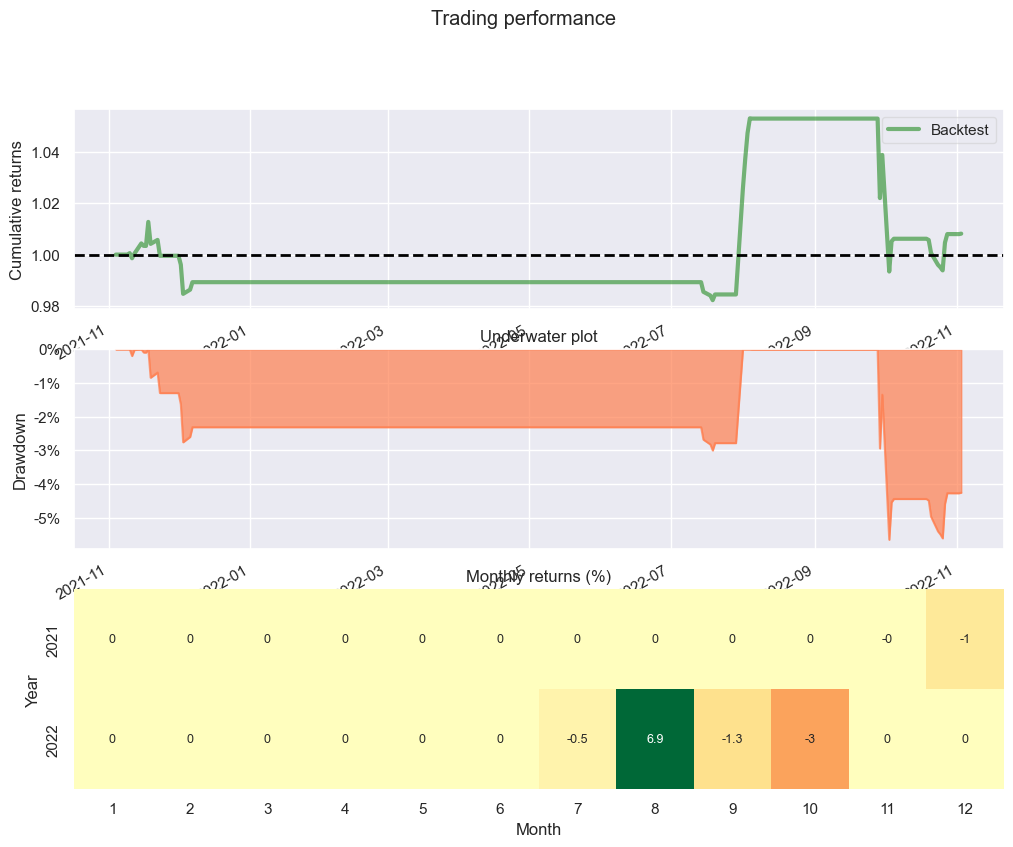

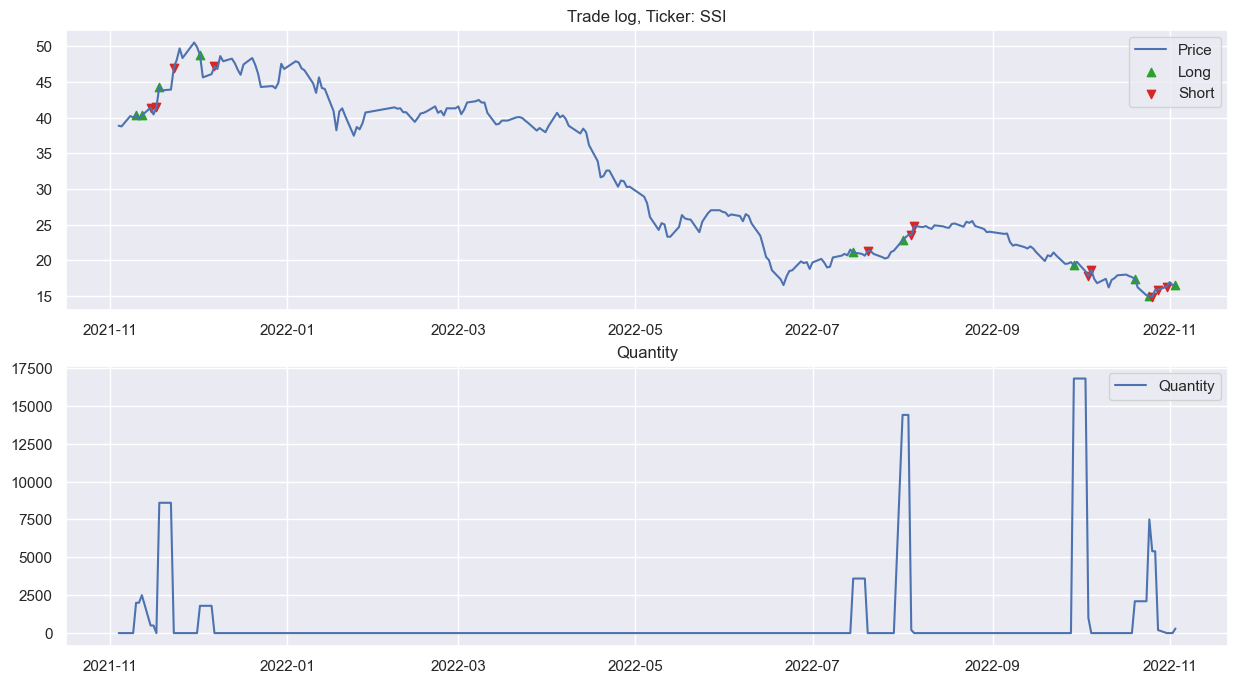

In [45]:
ENV_ID = 'VNALL-v0'
TASK = 'SSI'
ITH_ADAPT_STEP = 2

args = open_config('../configs/maml.yaml', env_id=ENV_ID)
envs = MetaVectorEnv([lambda: gym.make(ENV_ID) for _ in range(1)])
agent = MetaAgent(envs=envs, hiddens=args.hiddens)
agent.load_state_dict(params['maml']['SSI'][ITH_ADAPT_STEP])

envs.train(False)
envs.reset_task(TASK)

info = play_an_episode(agent, envs)
df = info["final_info"][0]["final_history"]

returns = df.set_index('time')["portfolio_value"].pct_change()
perf = create_performance(returns, plot=True)

plot_trade_log_v2(df)

# portfolio value from hodling
df["pv_from_holding"] = vbt.Portfolio.from_holding(
    df.close, init_cash=envs.envs[0].init_cash
).value()
df = df.set_index("time")
ticker = df["ticker_x"].unique()[0]

fig = go.Figure()
fig.update_layout(width=800, height=500)
fig.update_layout(title=f"Buy-n-Hold Comparision, Ticker: {ticker}", title_x=0.5)
fig.update_xaxes(title_text="Date")
fig.update_yaxes(title_text="Portfolio Value (VND)")

df["portfolio_value"].vbt.plot_against(
    other=df["pv_from_holding"],
    other_trace_kwargs=dict(
        line=dict(width=2, color="dimgray"), mode="lines", name="Buy-n-Hold"
    ),
    trace_kwargs=dict(
        mode="lines+markers",
        line=dict(width=3, color="lightslategray"),
        name="MAML",
    ),
    pos_trace_kwargs=dict(fillcolor="palegreen"),
    neg_trace_kwargs=dict(fillcolor="salmon"),
    fig=fig,
)
fig.show()

In [36]:
# # preprocess for plotting
# df_result = pd.DataFrame(results)
# df_result["mean-std"] = df_result["mean"] - df_result["std"]
# df_result["mean+std"] = df_result["mean"] + df_result["std"]
# maml_df = df_result[df_result.model_type == "maml"]
# random_df = df_result[df_result.model_type == "random"]

# fig = go.Figure()
# # adjust size Figure
# fig.update_layout(width=500, height=500)
# fig.update_layout(
#     title="Mean Reward +/- Std vs Number of Adaptation Steps", title_x=0.5
# )
# fig.update_xaxes(
#     title_text="Number of Adaptation Steps", dtick=1, range=[0, TOTAL_ADAPT_STEPS - 1]
# )
# fig.update_yaxes(title_text="Mean Reward +/- Std", dtick=100)

# plot_mean_reward(fig, maml_df, fill_color="lightcoral", line_color="red", name="MAML")
# plot_mean_reward(
#     fig, random_df, fill_color="lightskyblue", line_color="blue", name="Random"
# )

# fig.show()